In [1]:
import pandas as pd
import numpy as np

In [2]:
from transformers import BertTokenizer, BertModel
import torch

In [3]:
pip install openpyxl

In [4]:
df = pd.read_excel('data.xlsx') 

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
model = BertModel.from_pretrained("bert-large-uncased")

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
from tqdm import tqdm
sentence1 = []
sentence2 = []
sentences = []

for i in tqdm(range(len(df))):
    sentence1.append(df.iloc[i]['sentence1'])
    sentence2.append(df.iloc[i]['sentence2'])
    sentences.append(df.iloc[i]['sentence1'])
    sentences.append(df.iloc[i]['sentence2'])

100%|██████████████████████████████████████████████████████████████████████████████| 344/344 [00:00<00:00, 1291.83it/s]


In [7]:
tokens1 =[]
tokens2 =[]
tokens_1=[]
tokens_2=[]

for i in range(len(sentence1)):
    tokens1.append(tokenizer.tokenize(sentence1[i]))


for e in range(len(sentence2)):
    tokens2.append(tokenizer.tokenize(sentence2[e]))
    
for s1 in tokens1:
    tokens_1.append(['[CLS]'] + s1 + ['[SEP]'] + ['[PAD]'] * 2)
    
for s2 in tokens2:
    tokens_2.append(['[CLS]'] + s2 + ['[SEP]'] + ['[PAD]'] * 2)

In [9]:
attention_mask1 = []
attention_mask2 = []
for t in tokens_1:
    attention_mask1.append(1 if t != '[PAD]' else 0)
#attention_mask1 = [ 1 if t != '[PAD]' else 0 for t in tokens_1]
for t in tokens_2:
    attention_mask2.append(1 if t != '[PAD]' else 0)
#attention_mask2 = [ 1 if t != '[PAD]' else 0 for t in tokens_2]
 

In [10]:
ids1=[]
ids2=[]
ids_1 = []
ids_2 = []
re_ids1=[]
re_ids2=[]

for a in tokens1:
    ids1.append(tokenizer.convert_tokens_to_ids(a))

for f in tokens2:
    ids2.append(tokenizer.convert_tokens_to_ids(f))
    
for a in ids1:
    ids_1.append(torch.tensor(a))

for a in ids2:
    ids_2.append(torch.tensor(a))
    
for a in ids_1:
    re_ids1.append(torch.reshape(a, [1, -1]))

for a in ids_2:
    re_ids2.append(torch.reshape(a, [1, -1]))
    
   

In [13]:
attention1=[]
attention2=[]
attention11=[]
attention22=[]

for a in attention_mask1:
    attention1.append(torch.tensor(a))

for a in attention_mask2:
    attention2.append(torch.tensor(a))
    
for a in attention1:
    attention11.append(torch.reshape(a, [1, -1]))

for a in attention2:
    attention22.append(torch.reshape(a, [1, -1]))

In [15]:
model_outputs1 = []
model_outputs2 = []

for c,d in zip(re_ids1,attention11):
    model_outputs1.append(model(c,attention_mask = d))    
                          
for c,d in zip(re_ids2,attention22):
    model_outputs2.append(model(c,attention_mask = d))    

In [16]:
embeddings1 =[]
for d in range(len(model_outputs1)):
    embeddings1.append(model_outputs1[d]['last_hidden_state'][0])


embeddings2 =[]
for i in range(len(model_outputs2)):
    embeddings2.append(model_outputs2[i]['last_hidden_state'][0])

In [17]:
emb1=[]
for r in range(len(embeddings1)):
    emb1.append(embeddings1[r].detach().numpy())

emb2=[]
for r in range(len(embeddings2)):
    emb2.append(embeddings2[r].detach().numpy())


In [19]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances 

cos = []
euc = []
for x in range(len(emb1)):
    cos.append(cosine_similarity([emb1[x][0], emb2[x][1]])[0][1])
    euc.append(euclidean_distances([emb1[x][0], emb2[x][1]])[0][1])


In [20]:
from tqdm import tqdm
Aptness = []
hilo = []
average_score = []

for i in tqdm(range(len(df))):
    Aptness.append(df.iloc[i]['Aptness'])
    hilo.append(df.iloc[i]['hilo'])
    average_score.append(df.iloc[i]['average_score'])

100%|██████████████████████████████████████████████████████████████████████████████| 344/344 [00:00<00:00, 1368.73it/s]


In [21]:
import xlwt


file = xlwt.Workbook('encoding = utf-8') 
sheet1 = file.add_sheet('sheet1',cell_overwrite_ok=True)
sheet1.write(0, 0, "Sentence1")
sheet1.write(0, 1, "Sentence2")
sheet1.write(0, 2, "Aptness")
sheet1.write(0, 3, "hilo")
sheet1.write(0, 4, "average_score")
sheet1.write(0, 5, "cosine_similarity")
sheet1.write(0, 6, "euclidean_distances")

for i in range(len(df)):
    sheet1.write(i + 1, 0, sentence1[i])
    sheet1.write(i + 1, 1, sentence2[i])
    sheet1.write(i + 1, 2, Aptness[i])
    sheet1.write(i + 1, 3, int(hilo[i]))
    sheet1.write(i + 1, 4, average_score[i])
    sheet1.write(i + 1, 5, float(cos[i]))
    sheet1.write(i + 1, 6, float(euc[i]))

In [22]:
file.save('Similarity5.xls') 

In [23]:
df1 = pd.read_excel('Similarity5.xls') 
from tqdm import tqdm
hilo1 = []
hilo2 = []

for i in tqdm(range(len(df1))):
    hilo1.append(df1.iloc[i]['hilo'])
    hilo2.append(df1.iloc[i]['hilo_new'])

100%|██████████████████████████████████████████████████████████████████████████████| 344/344 [00:00<00:00, 5127.37it/s]


In [24]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(hilo1,hilo2)

In [25]:
auc_score

0.5901193252881722

In [9]:
inputs1 = tokenizer(sentence1,padding=True, return_tensors="pt")
outputs1 = model(**inputs1)

In [10]:
inputs2 = tokenizer(sentence2,padding=True, return_tensors="pt")
outputs2 = model(**inputs2)

In [11]:
cls_embs1 = outputs1['last_hidden_state'][:, 0]
cls_embs2 = outputs2['last_hidden_state'][:, 0]

In [12]:
np.shape(cls_embs1)

torch.Size([344, 512])

In [13]:
np.shape(cls_embs2)

torch.Size([344, 512])

In [64]:
emb1 = []
emb2 = []

In [65]:
for i in range(len(sentence1)):
    emb1.append(embeddings1[i].detach().numpy())
    emb2.append(embeddings2[i].detach().numpy())

In [59]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances 

In [67]:
cos = []
euc = []

In [68]:
for x in range(len(emb1)):
    cos.append(cosine_similarity([emb1[x], emb2[x]])[0][1])
    euc.append(euclidean_distances([emb1[x], emb2[x]])[0][1])


ValueError: Found array with dim 3. check_pairwise_arrays expected <= 2.

In [19]:
cos 

[0.87991786,
 0.78682625,
 0.9292643,
 0.9335138,
 0.80297196,
 0.813931,
 0.86551476,
 0.9419801,
 0.8669004,
 0.84700227,
 0.9272769,
 0.9126164,
 0.8322865,
 0.81512856,
 0.8491376,
 0.82885945,
 0.7607406,
 0.64019364,
 0.7794986,
 0.72182727,
 0.7607406,
 0.64019364,
 0.8451307,
 0.73807764,
 0.84912616,
 0.83513314,
 0.83487475,
 0.8861921,
 0.9232898,
 0.8821677,
 0.7896611,
 0.8363348,
 0.8553205,
 0.9382645,
 0.9310889,
 0.8621922,
 0.93220675,
 0.81364065,
 0.81078017,
 0.89636767,
 0.91017973,
 0.8959261,
 0.80199456,
 0.8890426,
 0.8981181,
 0.9999999,
 0.73419505,
 0.82426584,
 0.6884609,
 0.6109992,
 0.9644683,
 0.9415308,
 0.7802304,
 0.8730054,
 0.90131205,
 0.8535392,
 0.93311083,
 0.774717,
 0.9272332,
 0.9093774,
 0.89556384,
 0.85627556,
 0.87808084,
 0.83634907,
 0.7583182,
 0.7000294,
 0.7661648,
 0.8257556,
 0.8667362,
 0.82145965,
 0.8725694,
 0.81695354,
 0.87218034,
 0.8750279,
 0.7689423,
 0.7165858,
 0.9247509,
 0.8694278,
 0.87771976,
 0.76345026,
 0.880894

In [17]:
from tqdm import tqdm
Aptness = []
hilo = []
average_score = []

for i in tqdm(range(len(df))):
    Aptness.append(df.iloc[i]['Aptness'])
    hilo.append(df.iloc[i]['hilo'])
    average_score.append(df.iloc[i]['average_score'])

100%|██████████████████████████████████████████████████████████████████████████████| 344/344 [00:00<00:00, 3151.57it/s]


In [18]:
pip install xlwt

Note: you may need to restart the kernel to use updated packages.


In [19]:
import xlwt


file = xlwt.Workbook('encoding = utf-8') 
sheet1 = file.add_sheet('sheet1',cell_overwrite_ok=True)
sheet1.write(0, 0, "Sentence1")
sheet1.write(0, 1, "Sentence2")
sheet1.write(0, 2, "Aptness")
sheet1.write(0, 3, "hilo")
sheet1.write(0, 4, "average_score")
sheet1.write(0, 5, "cosine_similarity")
sheet1.write(0, 6, "euclidean_distances")

for i in range(len(df)):
    sheet1.write(i + 1, 0, sentence1[i])
    sheet1.write(i + 1, 1, sentence2[i])
    sheet1.write(i + 1, 2, Aptness[i])
    sheet1.write(i + 1, 3, int(hilo[i]))
    sheet1.write(i + 1, 4, average_score[i])
    sheet1.write(i + 1, 5, float(cos[i]))
    sheet1.write(i + 1, 6, float(euc[i]))
    

In [20]:
file.save('Similarity4.xls') 

I have modified my code as shown in the screenshot below. I calculated the average of the scores people gave to each set of sentences, after which I saved the sentences in two separate lists, sentence1 and sentence2, and tried to calculate the vector of sentences using cls, calculating cosine similarity and Euclidean distance for the sentences in sentence1 and sentence2 one by one. Finally save them to excel.
I am not sure if the thinking and approach is correct, do I need to add anything more or change anything?I also found that many of my calculations were the opposite of what people were scoring - is this reasonable, or is there something wrong with my calculations?

In [56]:
hilo = []
for i in range(0,344,2):
    if  cos[i-1] >= cos[i]:
        hilo.append('1')
    else: 
        hilo.append('0')
    

In [21]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [22]:
df1 = pd.read_excel('Similarity4.xls') 

In [23]:
from tqdm import tqdm
hilo1 = []
hilo2 = []

for i in tqdm(range(len(df1))):
    hilo1.append(df1.iloc[i]['hilo'])
    hilo2.append(df1.iloc[i]['hilo_new'])

100%|██████████████████████████████████████████████████████████████████████████████| 344/344 [00:00<00:00, 5226.13it/s]


In [24]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(hilo1,hilo2)

In [25]:
auc_score

0.5784910252509887

In [1]:
class neuralNetwork:
    
    
    # initialise the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # set number of nodes in each input, hidden, output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        # link weight matrices, wih and who
        # weights inside the arrays are w_i_j, where link is from node i to node j in the next layer
        # w11 w21
        # w12 w22 etc 
        self.wih = numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

        # learning rate
        self.lr = learningrate
        
        # activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)
        
        pass

In [2]:
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
model = BertModel.from_pretrained("bert-large-uncased")

NameError: name 'BertTokenizer' is not defined

In [ ]:
def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs

In [ ]:
# number of input, hidden and output nodes
input_nodes = 784
hidden_nodes = 200
output_nodes = 10

# learning rate
learning_rate = 0.1

# create instance of neural network
n = neuralNetwork(input_nodes,hidden_nodes,output_nodes, learning_rate)

In [ ]:
item = 2

# data is remaining values
inputs = our_own_dataset[item][1:]

# query the network
outputs = n.query(inputs)
print (outputs)


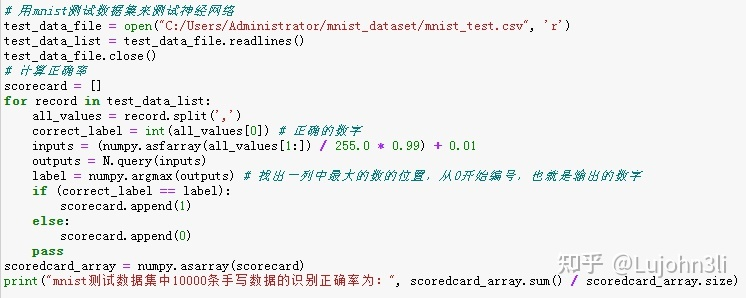

In [ ]:
scorecard = []
for record in test_data_list:
    inputs = (numpy.asfarray(all_values[1:])/255.0*0.99)+0.01
    outputs = N.query(inputs)
    